# REPEATED STRATIFIED HOLD-OUT

<br>

## Introduction

<br>
This evaluation method consists in repeating stratified hold-out validation $n$ times, in each iteration a certain proportion of stratified data is selected for training and for testing.


In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
#import sklearn.linear_model as lm
import sklearn.neighbors as nbr
import sklearn.metrics as mtr

import preprocessing as pre
import utilcompute as uc
from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_iris().data, load_iris().target) )
df = pd.DataFrame(data)
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'species']

#print('df.shape[0] : ', df.shape[0])


In [3]:
#df.describe()

In [4]:
# DATA PREPROCESSING : deleting features

to_delete = []
cols = [c for c in df.columns.values.tolist() if (c not in to_delete)]
df = df[cols]

#print('columns : ', df.columns.values.tolist())

In [5]:
target = 'species'
if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [6]:
# DATA PREPROCESSING : features standardization

vif_dict = uc.compute_vif(df = df, features = features)
print('df : ')
print()
pprint(vif_dict)

print()

df_std = pre.standardize(df = df, included = features, excluded = target)

vif_dict = uc.compute_vif(df = df_std, features = features)
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'petal length': 173.96896536339727,
 'petal width': 55.48868864572551,
 'sepal length': 264.7457109493044,
 'sepal width': 97.111605833803296}

df_std : 

{'petal length': 31.397291650719751,
 'petal width': 16.141563956997683,
 'sepal length': 7.1031134428332869,
 'sepal width': 2.0990386257420881}


In [7]:
# DATA PREPROCESSING : vif subset selection [reduces multicollinearity]

VIF = False

if (VIF):
    selected_features = uc.vif_best_subset_selection(
        vif_threshold = 5, 
        df = df_std, 
        features = features, 
        level = len(features), 
        debug = False
    )
    t = uc.concatenate(features, target)
    df_std = df_std[t]
    
    vif_dict = uc.compute_vif(df = df_std, features = selected_features)
    pprint(vif_dict)
else:
    selected_features = features


In [8]:
# DATA PREPROCESSING : final setup

df = df_std
features = selected_features

print(df_std.columns.values)

['petal length' 'petal width' 'sepal length' 'sepal width' 'species']


In [9]:
# GLOBAL PARAMETERS 

train_perc = 0.8
delimiter = int(len(df) * train_perc)
seeds = np.arange(1, 50 + 1)

print('train set size   : ', delimiter)
print('test  set size   : ', (len(df) - delimiter))
print()
print('seeds : {0} ... {1}'.format(seeds[:3], seeds[-3:]))


train set size   :  120
test  set size   :  30

seeds : [1 2 3] ... [48 49 50]


In [10]:
# [TEST]

SHOW_EXAMPLE = False

if (SHOW_EXAMPLE):
    for random_state in range(1, 10+1):
        X_train, X_test, y_train, y_test = train_test_split(
            df[features], df[target], 
            train_size = train_perc, 
            random_state = random_state, 
            stratify = df[target]
        )

        print('random state : ', random_state)
        print()
        print('X_train : {0} ... {1}'.format(X_train.index.values[:8], X_train.index.values[-8:]))
        print('y_train : {0} ... {1}'.format(y_train.index.values[:8], y_train.index.values[-8:]))
        print(y_train.value_counts(normalize = True, sort = True))

        print()
        print('X_test : {0} ... {1}'.format(X_test.index.values[:8], X_test.index.values[-8:]))
        print('y_test : {0} ... {1}'.format(y_test.index.values[:8], y_test.index.values[-8:]))
        print(y_test.value_counts(normalize = True, sort = True))
        print()
        print()

        fig, axs = plt.subplots(nrows = 1, ncols = 2 , figsize=(20, 4))  
        sns.countplot(y = y_train.values, ax = axs[0])
        sns.countplot(y = y_test.values, ax = axs[1])
        plt.show()

In [11]:
scores_train = []
scores_test = []

for (s_index, s) in enumerate(seeds):
    
    random_state = s
    
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], 
        df[target], 
        train_size = train_perc, 
        random_state = random_state, 
        stratify = df[target]
    )

    #model = lm.LogisticRegression()
    model = nbr.KNeighborsClassifier(n_neighbors = 5)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    #metrics_train = uc.compute_classification_metrics(y = y_train, y_pred = y_pred_train)
    #metrics_test = uc.compute_classification_metrics(y = y_test, y_pred = y_pred_test)
    
    acc_train = mtr.accuracy_score(y_true = y_train, y_pred = y_pred_train, normalize = True, sample_weight = None)
    acc_test = mtr.accuracy_score(y_true = y_test, y_pred = y_pred_test, normalize = True, sample_weight = None)

    #scores_train.append(1 - metrics_train['ACCURACY'])
    #scores_test.append(1 - metrics_test['ACCURACY'])
    
    scores_train.append(1 - acc_train)
    scores_test.append(1 - acc_test)
    

C:\Users\danis_p50\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
print()
print('train | err mean : ', np.mean(scores_train))
print('train | err std  : ', np.std(scores_train))

print()
print('test  | err mean : ', np.mean(scores_test))
print('test  | err std  : ', np.std(scores_test))



train | err mean :  0.0363333333333
train | err std  :  0.0105092551803

test  | err mean :  0.0526666666667
test  | err std  :  0.0320347034046


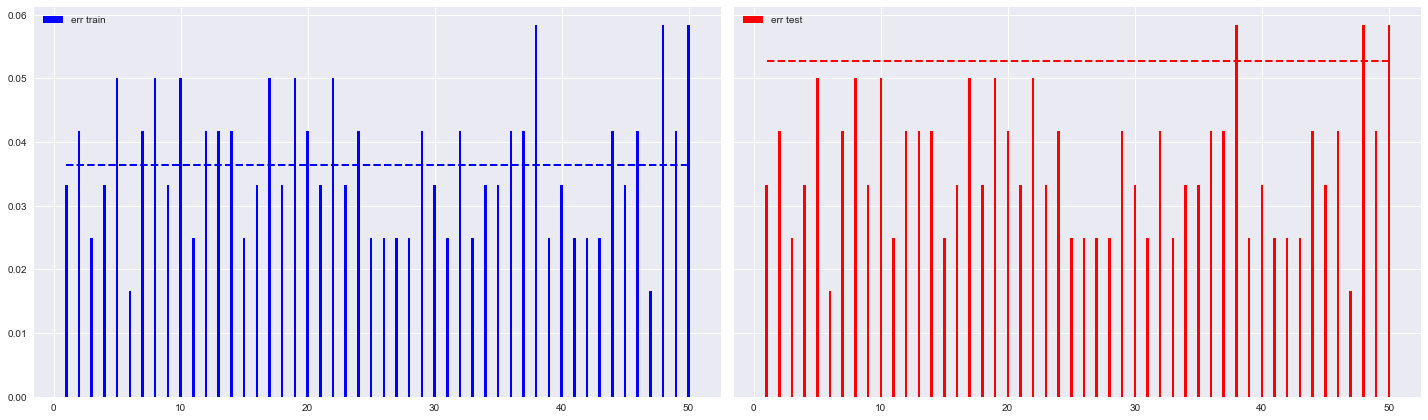

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 6), sharey = True) 

width = 0.2
tick_label = np.array( list(range(1, 101 + 1, 10)) ) -1
axs[0].bar(left = np.array(seeds), height = scores_train, width = width, align = 'center', color = 'blue', label = 'err train')
axs[0].plot( (min(seeds), max(seeds)), (np.mean(scores_train), np.mean(scores_train)), color = 'blue', lw = 2, linestyle = '--')
axs[0].legend(loc='best')

axs[1].bar(left = np.array(seeds), height = scores_train, width = width, align = 'center', color = 'red', label = 'err test')
axs[1].plot( (min(seeds), max(seeds)), (np.mean(scores_test), np.mean(scores_test)), color = 'red', lw = 2, linestyle = '--')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

## Considerations

<br>
Repeated stratified hold-out evaluation is likely the best hold-out evaluation algorithm, because it performs both stratification and repetition, thus mitigating the two major issues we have found so far :

<br>
<ul style="list-style-type:square">
    <li>
        stratification addresses the issue of the distribution of data between training and test sets, in other words, we no
        longer need to rely on random splits (the issue affects both hold-out and repeated hold-out)
    </li>
    <br>
    <li>
        repetition addresses the issue that some data points may never appear in training (or test) set, increasing the number
        of repetitions improves the probability of a data-point to be selected (sooner or later) for the training set (and the
        test set, for both actually) set (the issue affects both hold-out and stratified hold-out)
    </li>
</ul>

<br>
<b>Further questions/issues</b> :

<br>
<ul style="list-style-type:square">
    <li>
        the different test (or training) sets may overlap; <br>
        the repeated use of samples for testing results in performance estimates that become dependent between rounds, this
        dependence can be problematic for statistical comparisons (inherited from repeated hold-out)
    </li>
    <br>
    <li>
        the size we choose for the test set (inherited from hold-out validation)
    </li>
</ul>

<br>
<b>Note</b> : see Cross Validation - K Fold